In [1]:
import numpy as np
from library_dicom.dicom_processor.tools.create_mip import *
import matplotlib.pyplot as plt
#from radiomics.featureextractor import *
from sklearn import mixture

from library_dicom.post_processing.PostProcess_Reader import PostProcess_Reader
from library_dicom.post_processing.Mask4D import Mask4D
#from library_dicom.post_processing.GaussianModel import GaussianModel
from library_dicom.post_processing.WatershedModel import WatershedModel 
from library_dicom.dicom_processor.tools.folders import *
from library_dicom.dicom_processor.tools.threshold_mask import *

In [2]:
#First Example with 4D mask , threshold = 3

In [2]:
import SimpleITK as sitk  
#mask_path = r'C:\Users\wendy\Documents\STAGE\gained\1.2.250.1.74.20130607110000.4000014017745_nifti_mask.nii'
#pet_path = r'C:\Users\wendy\Documents\STAGE\gained\1.2.250.1.74.20130607110000.4000014017745_nifti_PT.nii'

mask_path = '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/GAINED_NIFTI/11011101061005/pet0/1.2.250.1.74.20130607110000.4000014017745_nifti_mask.nii'
pet_path = '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/GAINED_NIFTI/11011101061005/pet0/1.2.250.1.74.20130607110000.4000014017745_nifti_PT.nii'

In [4]:
model = WatershedModel(mask_path, pet_path, type = '4d')

In [5]:
ws_array, label_number = model.watershed_model(3)

In [6]:
label_number 

21

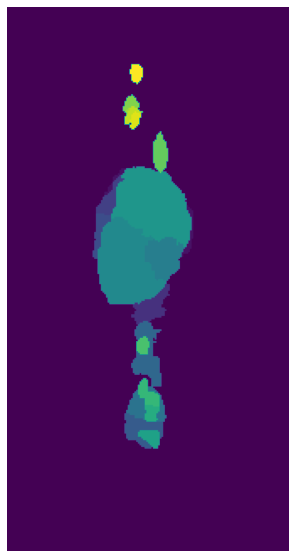

In [7]:
mip_imshow(ws_array, 0, cmap='viridis', type = 'mask', vmin = None, vmax = None)

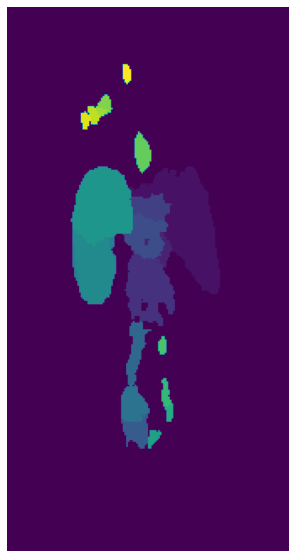

In [8]:
mip_imshow(ws_array, 90, cmap='viridis', type = 'mask', vmin=None, vmax=None)

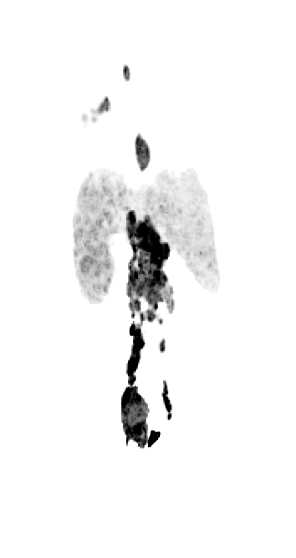

In [9]:
suv_values = model.get_pet_view(model.pet_array, ws_array)
mip_imshow(suv_values, 90, cmap='Greys', type = 'pet', vmin = 3, vmax = 22 )

In [10]:
study_uid ='test'
path_image = '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/post_processing/results_ahl'

mip_projection(suv_values, 90, path_image, study_uid, type='pet', cmap='Greys', vmin = 3, vmax = 22)

'/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/post_processing/results_ahl/test_mip_pet_90.png'

for i in range(1, label_number + 1):
    new_mask = np.zeros((model.size_matrix))
    x,y,z = np.where(ws_array == i)

    for j in range(len(x)):
        new_mask[x[j], y[j], z[j]] = i

    mip_imshow(new_mask, 90, cmap='viridis', type='mask')

In [ ]:
#Other example : AHL prédictions mask, thresold = 0.5

In [2]:
import csv
import SimpleITK as sitk

In [3]:
csv_ahl_post_process= '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/post_processing/ahl_post_process_ecart_volume_40_max.csv'

with open(csv_ahl_post_process, 'r') as csv_file :
    reader = csv.reader(csv_file, delimiter = ',') #liste pour chaque ligne 
    csv_data = []
    for row in reader :
        csv_data.append(row)
        
del csv_data[0] #enlever première ligne

In [4]:
csv_data[5]

['13011101251033',
 '1.2.840.113619.2.290.3.17436513.549.1392878181.627',
 '/media/deeplearning/Elements/AHL2011_NIFTI/1.2.840.113619.2.290.3.17436513.549.1392878181.627_nifti_PT.nii',
 '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/inference/1.2.840.113619.2.290.3.17436513.549.1392878181.627_mask_pred_float.nii',
 '/media/deeplearning/Elements/AHL2011_CSV_DATA/AHL2011-CSV/mag_pa_feb 20_2014.csv',
 '233.02',
 '302.8300000000001',
 '69.81000000000009']

In [5]:
results_directory = '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/post_processing/results_ahl'
error = []
path_mip = []

tmtv = []
for serie in csv_data : 
    print(csv_data.index(serie))
    subliste = []
    try : 
        model = WatershedModel(serie[3], serie[2], type = '3d')
        ws_array, label_number = model.watershed_model(0.5)

        folder = results_directory+'/'+serie[1]
        if not os.path.exists(folder):
            os.makedirs(folder) 


        angle_filename_mask = mip_projection(ws_array, 90, folder, serie[1], type ='mask', cmap='viridis', vmin = None, vmax = None)
        print("MIP MASK 90")
        subliste.append(angle_filename_mask)
        suv_values_array = model.get_pet_view(model.pet_array, ws_array)
        angle_filename_pet = mip_projection(suv_values_array, 90, folder, serie[1], type='pet', cmap='Greys', vmin = 3, vmax = 13 )
        subliste.append(angle_filename_pet)
        print("MIP PET 90")
        subliste.append(serie[1])
        subliste.append(label_number)
        path_mip.append(subliste)

        other_angle = []
        angle_filename_mask_0 = mip_projection(ws_array, 0, folder, serie[1], type ='mask', cmap='viridis', vmin = None, vmax = None)
        other_angle.append(angle_filename_mask_0)
        print("MIP MASK 0")
        angle_filename_pet_0 = mip_projection(suv_values_array, 0, folder, serie[1], type='pet', cmap='Greys', vmin = 3, vmax = 13 )

        other_angle.append(angle_filename_pet_0)
        print("MIP PET 0")
        other_angle.append(serie[1])
        other_angle.append(label_number)
        path_mip.append(other_angle)

        ws_array = get_threshold_matrix(ws_array, model.pet_array, label_number, 0.41)
        img = sitk.GetImageFromArray(ws_array)
        img2 = sitk.GetImageFromArray(ws_array.transpose())
        img.SetDirection(model.pet_direction)
        img.SetOrigin(model.pet_origin)
        img.SetSpacing(model.pet_spacing)
        img2.SetDirection(model.pet_direction)
        img2.SetOrigin(model.pet_origin)
        img2.SetSpacing(model.pet_spacing)
        filename = folder+'/'+serie[1]+'_nifti_mask.nii'
        sitk.WriteImage(img, filename)

        json_details = model.label_stat_results(img2)
        tmtv.append(json_details['total_vol'])
        write_json_file(folder, serie[1]+'_details', json_details)


    except Exception as err : 
        print(err)
        print(serie)
        error.append(serie)

0
MIP MASK 90
MIP PET 90
MIP MASK 0
MIP PET 0
1
MIP MASK 90
MIP PET 90
MIP MASK 0
MIP PET 0
2
MIP MASK 90
MIP PET 90
MIP MASK 0
MIP PET 0
3
MIP MASK 90
MIP PET 90
MIP MASK 0
MIP PET 0
4
MIP MASK 90
MIP PET 90
MIP MASK 0
MIP PET 0
5
MIP MASK 90
MIP PET 90
MIP MASK 0
MIP PET 0
6
MIP MASK 90
MIP PET 90
MIP MASK 0
MIP PET 0
7
MIP MASK 90
MIP PET 90
MIP MASK 0
MIP PET 0
8
MIP MASK 90
MIP PET 90
MIP MASK 0
MIP PET 0
9
MIP MASK 90
MIP PET 90
MIP MASK 0
MIP PET 0
10
MIP MASK 90
MIP PET 90
MIP MASK 0
MIP PET 0
11
MIP MASK 90
MIP PET 90
MIP MASK 0
MIP PET 0
12
MIP MASK 90
MIP PET 90
MIP MASK 0
MIP PET 0
13
MIP MASK 90
MIP PET 90
MIP MASK 0
MIP PET 0
14
MIP MASK 90
MIP PET 90
MIP MASK 0
MIP PET 0
15
MIP MASK 90
MIP PET 90
MIP MASK 0
MIP PET 0
16
MIP MASK 90
MIP PET 90
MIP MASK 0
MIP PET 0
17
MIP MASK 90
MIP PET 90
MIP MASK 0
MIP PET 0
18
MIP MASK 90
MIP PET 90
MIP MASK 0
MIP PET 0
19
MIP MASK 90
MIP PET 90
MIP MASK 0
MIP PET 0
20
MIP MASK 90
MIP PET 90
MIP MASK 0
MIP PET 0
21
MIP MASK 90
MIP PET 

In [6]:
filename = os.path.join(results_directory, 'list_mip_min_dist16_6connex_V2.pdf')
create_pdf_mip(path_mip, filename) 

In [6]:
tmtv

[280.9697188201244,
 1988.8077489461987,
 1001.3885958436003,
 179.584,
 91.32203939653316,
 306.29904606495984,
 126.4154835664368,
 234.78526016617252,
 563.0885480461438,
 138.77341838000575,
 363.9501596202899,
 102.96200133603341,
 242.81600000000003,
 1052.3895385392825,
 499.3347070337291,
 351.68,
 205.64186434006842,
 258.0232975028434,
 819.8789451608824,
 787.834201491205,
 221.5680264129639,
 240.70398565292356,
 299.01614565152687,
 583.6749434796867,
 580.5322690830766,
 792.8960000000001,
 504.64255031226133,
 497.08799999999997,
 569.2785229368055,
 235.264,
 402.7058294819708,
 663.2078483044461,
 875.711947803497,
 1712.357500235613,
 1335.105861505141,
 515.2721637877992,
 966.8326691663185,
 1298.6371038924046,
 1672.8549377480642,
 1088.511935119629]

In [7]:
csv_post = '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/post_processing/ahl_post_process_ecart_volume_40_max.csv'

with open(csv_post, 'r') as csv_file :
    reader = csv.reader(csv_file, delimiter = ',') #liste pour chaque ligne 
    csv_data_2 = []
    for row in reader :
        csv_data_2.append(row)
        
del csv_data_2[0] #enlever première ligne


In [8]:
csv_data_2[0]

['53011101371012',
 '1.2.250.1.74.20140306150000.1000040424629',
 '/media/deeplearning/Elements/AHL2011_NIFTI/1.2.250.1.74.20140306150000.1000040424629_nifti_PT.nii',
 '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/inference/1.2.250.1.74.20140306150000.1000040424629_mask_pred_float.nii',
 '/media/deeplearning/Elements/AHL2011_CSV_DATA/AHL2011-CSV/ber_gu_feb 24_2014_SK.csv',
 '268.45',
 '334.27000000000004',
 '65.82000000000005']

In [9]:
volume_total_csv = []
for row in csv_data_2 : 
    volume_total_csv.append(row[5])

In [10]:
#diff cs manual et auto
diff = []
for i in range(len(tmtv)):
    diff.append(tmtv[i] - float(volume_total_csv[i]))

In [11]:
diff

[12.51971882012441,
 686.1277489461986,
 381.5285958436003,
 -13.566000000000003,
 -649.3079606034669,
 73.27904606495983,
 -370.60451643356316,
 -128.4347398338275,
 -1.5414519538561535,
 -11.666581619994247,
 92.2201596202899,
 -74.00799866396659,
 54.84600000000003,
 55.83953853928256,
 103.20470703372911,
 -75.70999999999998,
 -40.85813565993158,
 -34.61670249715661,
 -159.73105483911763,
 -21.705798508794942,
 -131.3919735870361,
 -413.63601434707647,
 65.36614565152686,
 174.47494347968671,
 -36.11773091692339,
 154.04600000000005,
 139.21255031226133,
 -39.61200000000008,
 179.1185229368055,
 -851.9060000000001,
 65.3958294819708,
 218.0578483044461,
 -936.828052196503,
 463.29750023561314,
 161.68586150514102,
 -360.6178362122008,
 117.32266916631852,
 517.0971038924047,
 729.3749377480642,
 -120.95806488037101]

In [12]:
#write csv 
nifti_directory = '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/post_processing'

with open(os.path.join(nifti_directory, 'ahl_post_process_tmtv.csv'), 'w') as csv_file : 
    csv_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(["PATIENT ID", "STUDY UID", "NIFTI_PET", "NIFTI_MASK", "CSV", "VOL_TOTAL", "SUM_ROI_VOLUME", "DIFF", "WS_VOL", "DIFF_WS_CSV"])
    for serie in csv_data_2: 
        index = csv_data_2.index(serie)
        csv_writer.writerow([serie[0], serie[1], serie[2], serie[3], serie[4], serie[5], serie[6], serie[7], tmtv[index], diff[index]])